# Probabilistic Bayesian Neural Networks
https://keras.io/examples/keras_recipes/bayesian_neural_networks/

## Setup

### Ambiente
Creamos un ambiente con la paquetería necesaria

``conda create -n env_tf_bayes``

``conda activate env_tf_bayes``

``pip install tensorflow-probability``

``pip install tensorflow-datasets``

### Bibliotecas

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import pandas as pd
import matplotlib.pyplot as plt

2025-04-18 10:20:42.871642: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/saraluz/miniconda3/envs/tf_bayes/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create training and evaluation datasets

In [2]:
############# Código original
# def get_train_and_test_splits(train_size, batch_size=1):
#     # We prefetch with a buffer the same size as the dataset because th dataset
#     # is very small and fits into memory.
#     dataset = (
#         tfds.load(name="wine_quality", as_supervised=True, split="train")
#         .map(lambda x, y: (x, tf.cast(y, tf.float32)))
#         .prefetch(buffer_size=dataset_size)
#         .cache()
#     )
#     # We shuffle with a buffer the same size as the dataset.
#     train_dataset = (
#         dataset.take(train_size).shuffle(buffer_size=train_size).batch(batch_size)
#     )
#     test_dataset = dataset.skip(train_size).batch(batch_size)

#     return train_dataset, test_dataset

In [3]:
def get_train_and_test_splits(train_size, batch_size=1):
    # Importar datos
    data = pd.read_csv("./../data/train_wine.csv")

    # VARIABLE OBJETIVO Y VARIABLES INDEPENDIENTES
    features = data.drop(columns=["quality", "id"])
    labels = data["quality"]

    # Convertir a tensores de TensorFlow
    features_dict = {col: tf.convert_to_tensor(features[col].values, dtype=tf.float32) for col in features.columns}
    labels_tensor = tf.convert_to_tensor(labels.values, dtype=tf.float32)

    # Crear dataset de TensorFlow
    dataset = tf.data.Dataset.from_tensor_slices((features_dict, labels_tensor))
    dataset = dataset.cache().shuffle(len(data)).prefetch(buffer_size=tf.data.AUTOTUNE)

    # Definir train_size y test_size correctamente
    test_size = len(data) - train_size  # Corregir tamaño del dataset de prueba

    train_dataset = dataset.take(train_size).batch(batch_size)
    test_dataset = dataset.skip(train_size).take(test_size).batch(batch_size)  # Agregar `take(test_size)`

    return train_dataset, test_dataset

## Compile, train, and evaluate the model

In [4]:
hidden_units = [8, 8]
learning_rate = 0.001


# def run_experiment(model, loss, train_dataset, test_dataset):

#     model.compile(
#         optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
#         loss=loss,
#         metrics=[keras.metrics.RootMeanSquaredError()],
#     )

#     print("Start training the model...")
#     model.fit(train_dataset, epochs=num_epochs, validation_data=test_dataset)
#     print("Model training finished.")
#     _, rmse = model.evaluate(train_dataset, verbose=0)
#     print(f"Train RMSE: {round(rmse, 3)}")

#     print("Evaluating model performance...")
#     _, rmse = model.evaluate(test_dataset, verbose=0)
#     print(f"Test RMSE: {round(rmse, 3)}")


def run_experiment(model, loss, train_dataset, test_dataset):
    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate),
        loss=loss,
        metrics=[keras.metrics.RootMeanSquaredError()],
    )

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=test_dataset
    )
    print("Model training finished.")

    # Evaluate model
    _, rmse_train = model.evaluate(train_dataset, verbose=0)
    _, rmse_test = model.evaluate(test_dataset, verbose=0)
    print(f"Train RMSE: {round(rmse_train, 3)}")
    print(f"Test RMSE: {round(rmse_test, 3)}")

    # Plot loss and RMSE
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # RMSE plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history["root_mean_squared_error"], label="Train RMSE")
    plt.plot(history.history["val_root_mean_squared_error"], label="Val RMSE")
    plt.title("RMSE over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()

    plt.tight_layout()
    plt.show()

## Create model inputs

In [5]:
FEATURE_NAMES = [
    "fixed acidity",
    "volatile acidity",
    "citric acid",
    "residual sugar",
    "chlorides",
    "free sulfur dioxide",
    "total sulfur dioxide",
    "density",
    "pH",
    "sulphates",
    "alcohol",
]


def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        inputs[feature_name] = layers.Input(
            name=feature_name, shape=(1,), dtype=tf.float32
        )
    return inputs


## Experiment 1: standard neural network
We create a standard deterministic neural network model as a baseline.

In [6]:

def create_baseline_model():
    inputs = create_model_inputs()
    input_values = [value for _, value in sorted(inputs.items())]
    features = keras.layers.concatenate(input_values)
    features = layers.BatchNormalization()(features)

    # Create hidden layers with deterministic weights using the Dense layer.
    for units in hidden_units:
        features = layers.Dense(units, activation="sigmoid")(features)
    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


Let's split the wine dataset into training and test sets, with 85% and 15% of the examples, respectively.

In [7]:
data = pd.read_csv("./../data/train_wine.csv")
dataset_size = data.shape[0]
batch_size = 256
train_size = int(dataset_size * 0.85)
train_dataset, test_dataset = get_train_and_test_splits(train_size, batch_size)

2025-04-18 10:20:49.315958: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Now let's train the baseline model. We use the MeanSquaredError as the loss function.

Start training the model...
Epoch 1/100


2025-04-18 10:20:49.803188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype float and shape [15000]
	 [[{{node Placeholder/_8}}]]
2025-04-18 10:20:49.804084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [15000]
	 [[{{node Placeholder/_10}}]]


45/50 [==========================>...] - ETA: 0s - loss: 35.6296 - root_mean_squared_error: 5.9691

2025-04-18 10:20:51.218463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype float and shape [15000]
	 [[{{node Placeholder/_7}}]]
2025-04-18 10:20:51.223010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [15000]
	 [[{{node Placeholder/_1}}]]


50/50 [==============================] - 2s 17ms/step - loss: 35.3424 - root_mean_squared_error: 5.9449 - val_loss: 32.9553 - val_root_mean_squared_error: 5.7407
Epoch 2/100
50/50 [==============================] - 1s 13ms/step - loss: 29.6362 - root_mean_squared_error: 5.4439 - val_loss: 26.4257 - val_root_mean_squared_error: 5.1406
Epoch 3/100
50/50 [==============================] - 1s 12ms/step - loss: 24.4635 - root_mean_squared_error: 4.9461 - val_loss: 21.4952 - val_root_mean_squared_error: 4.6363
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 19.9645 - root_mean_squared_error: 4.4682 - val_loss: 17.3936 - val_root_mean_squared_error: 4.1706
Epoch 5/100
50/50 [==============================] - 1s 11ms/step - loss: 16.0802 - root_mean_squared_error: 4.0100 - val_loss: 14.1248 - val_root_mean_squared_error: 3.7583
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 12.9293 - root_mean_squared_error: 3.5957 - val_loss: 11.2068 - val_

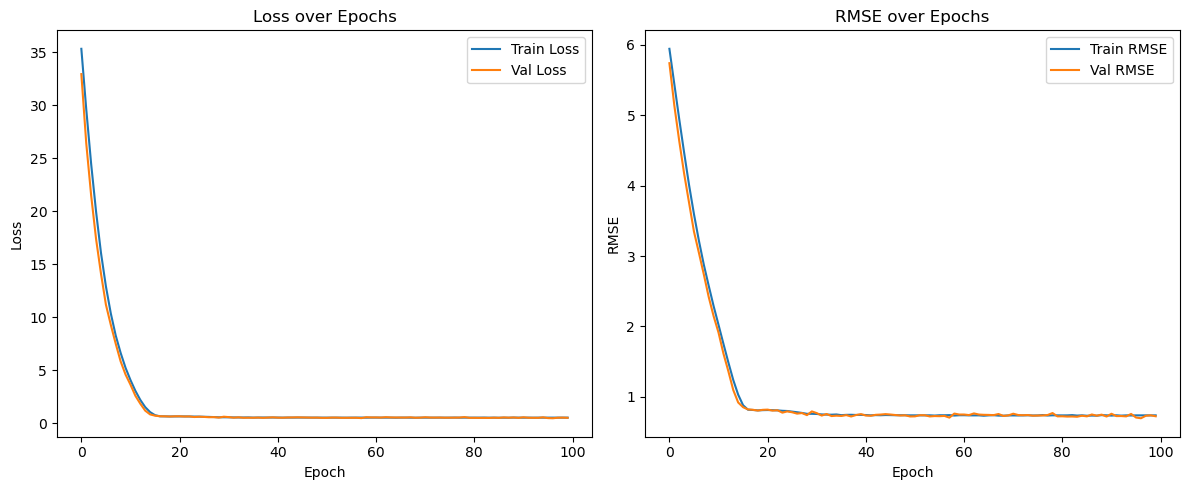

In [8]:
num_epochs = 100
mse_loss = keras.losses.MeanSquaredError()
baseline_model = create_baseline_model()
run_experiment(baseline_model, mse_loss, train_dataset, test_dataset)

We take a sample from the test set use the model to obtain predictions for them. Note that since the baseline model is deterministic, we get a single a point estimate prediction for each test example, with no information about the uncertainty of the model nor the prediction.

In [9]:
sample = 10
examples, targets = list(test_dataset.unbatch().shuffle(batch_size * 10).batch(sample))[
    0
]

predicted = baseline_model(examples).numpy()
for idx in range(sample):
    print(f"Predicted: {round(float(predicted[idx][0]), 1)} - Actual: {targets[idx]}")

2025-04-18 10:22:08.471072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype float and shape [15000]
	 [[{{node Placeholder/_2}}]]
2025-04-18 10:22:08.472562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [15000]
	 [[{{node Placeholder/_0}}]]


Predicted: 6.3 - Actual: 5.0
Predicted: 5.6 - Actual: 7.0
Predicted: 5.3 - Actual: 6.0
Predicted: 6.0 - Actual: 5.0
Predicted: 6.3 - Actual: 6.0
Predicted: 5.3 - Actual: 6.0
Predicted: 5.5 - Actual: 5.0
Predicted: 6.2 - Actual: 7.0
Predicted: 5.5 - Actual: 6.0
Predicted: 5.4 - Actual: 5.0


## Experiment 2: Bayesian neural network (BNN)

The object of the Bayesian approach for modeling neural networks is to capture the epistemic uncertainty, which is uncertainty about the model fitness, due to limited training data.

The idea is that, instead of learning specific weight (and bias) values in the neural network, the Bayesian approach learns weight distributions - from which we can sample to produce an output for a given input - to encode weight uncertainty.

Thus, we need to define prior and the posterior distributions of these weights, and the training process is to learn the parameters of these distributions.

In [10]:
# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


We use the tfp.layers.DenseVariational layer instead of the standard keras.layers.Dense layer in the neural network model.

In [11]:

def create_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # The output is deterministic: a single point estimate.
    outputs = layers.Dense(units=1)(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


The epistemic uncertainty can be reduced as we increase the size of the training data. That is, the more data the BNN model sees, the more it is certain about its estimates for the weights (distribution parameters). Let's test this behaviour by training the BNN model on a small subset of the training set, and then on the full training set, to compare the output variances.

### Train BNN with a small training subset.

Start training the model...
Epoch 1/500


2025-04-18 10:22:09.737954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [15000]
	 [[{{node Placeholder/_10}}]]
2025-04-18 10:22:09.738830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [15000]
	 [[{{node Placeholder/_1}}]]


15/15 [==============================] - 4s 114ms/step - loss: 27.4905 - root_mean_squared_error: 5.2427 - val_loss: 26.8393 - val_root_mean_squared_error: 5.1802
Epoch 2/500
15/15 [==============================] - 1s 35ms/step - loss: 25.0197 - root_mean_squared_error: 5.0015 - val_loss: 23.7729 - val_root_mean_squared_error: 4.8752
Epoch 3/500
15/15 [==============================] - 0s 25ms/step - loss: 23.8584 - root_mean_squared_error: 4.8840 - val_loss: 23.0116 - val_root_mean_squared_error: 4.7965
Epoch 4/500
15/15 [==============================] - 1s 30ms/step - loss: 23.6615 - root_mean_squared_error: 4.8638 - val_loss: 23.2281 - val_root_mean_squared_error: 4.8191
Epoch 5/500
15/15 [==============================] - 1s 37ms/step - loss: 21.6332 - root_mean_squared_error: 4.6506 - val_loss: 20.7209 - val_root_mean_squared_error: 4.5515
Epoch 6/500
15/15 [==============================] - 1s 38ms/step - loss: 20.0671 - root_mean_squared_error: 4.4791 - val_loss: 22.7856 - val

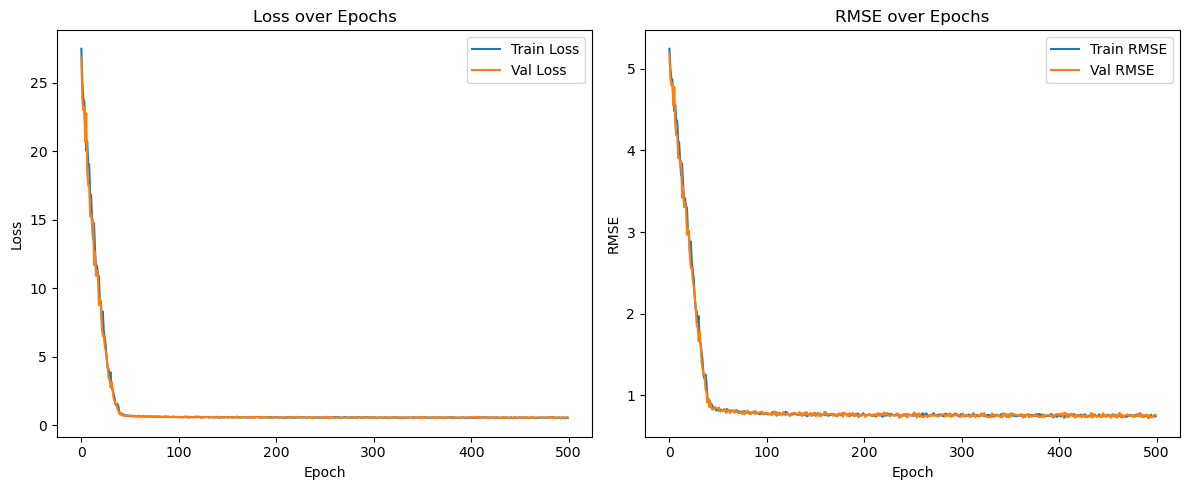

In [12]:
num_epochs = 500
train_sample_size = int(train_size * 0.3)
small_train_dataset = train_dataset.unbatch().take(train_sample_size).batch(batch_size)

bnn_model_small = create_bnn_model(train_sample_size)
run_experiment(bnn_model_small, mse_loss, small_train_dataset, test_dataset)

Since we have trained a BNN model, the model produces a different output each time we call it with the same input, since each time a new set of weights are sampled from the distributions to construct the network and produce an output. The less certain the mode weights are, the more variability (wider range) we will see in the outputs of the same inputs.

In [13]:

def compute_predictions(model, iterations=100):
    predicted = []
    for _ in range(iterations):
        predicted.append(model(examples).numpy())
    predicted = np.concatenate(predicted, axis=1)

    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()

    for idx in range(sample):
        print(
            f"Predictions mean: {round(prediction_mean[idx], 2)}, "
            f"min: {round(prediction_min[idx], 2)}, "
            f"max: {round(prediction_max[idx], 2)}, "
            f"range: {round(prediction_range[idx], 2)} - "
            f"Actual: {targets[idx]}"
        )


compute_predictions(bnn_model_small)

Predictions mean: 6.15, min: 5.92, max: 6.31, range: 0.38 - Actual: 5.0
Predictions mean: 5.61, min: 5.34, max: 6.0, range: 0.66 - Actual: 7.0
Predictions mean: 5.37, min: 4.98, max: 5.8, range: 0.82 - Actual: 6.0
Predictions mean: 6.0, min: 5.75, max: 6.22, range: 0.47 - Actual: 5.0
Predictions mean: 6.19, min: 5.94, max: 6.33, range: 0.39 - Actual: 6.0
Predictions mean: 5.28, min: 4.92, max: 5.74, range: 0.82 - Actual: 6.0
Predictions mean: 5.51, min: 5.27, max: 5.91, range: 0.64 - Actual: 5.0
Predictions mean: 6.12, min: 5.84, max: 6.29, range: 0.45 - Actual: 7.0
Predictions mean: 5.45, min: 5.13, max: 5.87, range: 0.74 - Actual: 6.0
Predictions mean: 5.33, min: 4.97, max: 5.78, range: 0.81 - Actual: 5.0


### Train BNN with the whole training set.

Start training the model...
Epoch 1/500
50/50 [==============================] - 3s 26ms/step - loss: 31.9626 - root_mean_squared_error: 5.6534 - val_loss: 29.0177 - val_root_mean_squared_error: 5.3867
Epoch 2/500
50/50 [==============================] - 1s 16ms/step - loss: 26.8925 - root_mean_squared_error: 5.1857 - val_loss: 23.7085 - val_root_mean_squared_error: 4.8690
Epoch 3/500
50/50 [==============================] - 1s 17ms/step - loss: 22.2006 - root_mean_squared_error: 4.7116 - val_loss: 19.9216 - val_root_mean_squared_error: 4.4632
Epoch 4/500
50/50 [==============================] - 1s 15ms/step - loss: 19.2091 - root_mean_squared_error: 4.3826 - val_loss: 17.5412 - val_root_mean_squared_error: 4.1880
Epoch 5/500
50/50 [==============================] - 1s 14ms/step - loss: 16.0164 - root_mean_squared_error: 4.0018 - val_loss: 13.8146 - val_root_mean_squared_error: 3.7166
Epoch 6/500
50/50 [==============================] - 1s 14ms/step - loss: 12.9938 - root_mean_squared_

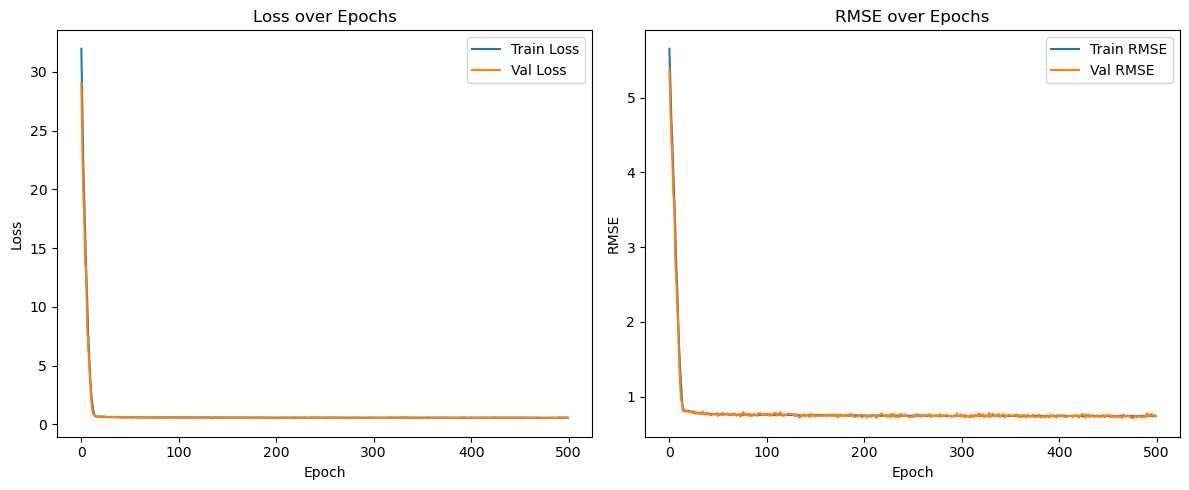

Predictions mean: 6.27, min: 6.13, max: 6.36, range: 0.23 - Actual: 5.0
Predictions mean: 5.53, min: 5.31, max: 5.69, range: 0.39 - Actual: 7.0
Predictions mean: 5.35, min: 5.19, max: 5.49, range: 0.31 - Actual: 6.0
Predictions mean: 6.0, min: 5.79, max: 6.16, range: 0.37 - Actual: 5.0
Predictions mean: 6.31, min: 6.16, max: 6.38, range: 0.22 - Actual: 6.0
Predictions mean: 5.33, min: 5.18, max: 5.47, range: 0.29 - Actual: 6.0
Predictions mean: 5.49, min: 5.28, max: 5.71, range: 0.43 - Actual: 5.0
Predictions mean: 6.21, min: 6.05, max: 6.32, range: 0.27 - Actual: 7.0
Predictions mean: 5.46, min: 5.29, max: 5.64, range: 0.35 - Actual: 6.0
Predictions mean: 5.38, min: 5.22, max: 5.53, range: 0.31 - Actual: 5.0


In [14]:
num_epochs = 500
bnn_model_full = create_bnn_model(train_size)
run_experiment(bnn_model_full, mse_loss, train_dataset, test_dataset)

compute_predictions(bnn_model_full)

## Experiment 3: probabilistic Bayesian neural network
So far, the output of the standard and the Bayesian NN models that we built is deterministic, that is, produces a point estimate as a prediction for a given example. We can create a probabilistic NN by letting the model output a distribution. In this case, the model captures the aleatoric uncertainty as well, which is due to irreducible noise in the data, or to the stochastic nature of the process generating the data.

In this example, we model the output as a IndependentNormal distribution, with learnable mean and variance parameters. If the task was classification, we would have used IndependentBernoulli with binary classes, and OneHotCategorical with multiple classes, to model distribution of the model output.

In [15]:

def create_probablistic_bnn_model(train_size):
    inputs = create_model_inputs()
    features = keras.layers.concatenate(list(inputs.values()))
    features = layers.BatchNormalization()(features)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        features = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        )(features)

    # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
    # to produce the parameters of the distribution.
    # We set units=2 to learn both the mean and the variance of the Normal distribution.
    distribution_params = layers.Dense(units=2)(features)
    outputs = tfp.layers.IndependentNormal(1)(distribution_params)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


Since the output of the model is a distribution, rather than a point estimate, we use the negative loglikelihood as our loss function to compute how likely to see the true data (targets) from the estimated distribution produced by the model.

Start training the model...
Epoch 1/1000
50/50 [==============================] - 4s 26ms/step - loss: 33.7161 - root_mean_squared_error: 6.2754 - val_loss: 28.3150 - val_root_mean_squared_error: 6.2561
Epoch 2/1000
50/50 [==============================] - 1s 13ms/step - loss: 20.1392 - root_mean_squared_error: 6.0339 - val_loss: 18.1251 - val_root_mean_squared_error: 6.0424
Epoch 3/1000
50/50 [==============================] - 1s 15ms/step - loss: 13.3904 - root_mean_squared_error: 5.8341 - val_loss: 11.6078 - val_root_mean_squared_error: 5.7948
Epoch 4/1000
50/50 [==============================] - 1s 14ms/step - loss: 9.7264 - root_mean_squared_error: 5.6039 - val_loss: 8.6004 - val_root_mean_squared_error: 5.5586
Epoch 5/1000
50/50 [==============================] - 1s 15ms/step - loss: 6.9742 - root_mean_squared_error: 5.4455 - val_loss: 5.9898 - val_root_mean_squared_error: 5.2589
Epoch 6/1000
50/50 [==============================] - 1s 14ms/step - loss: 5.1317 - root_mean_squared

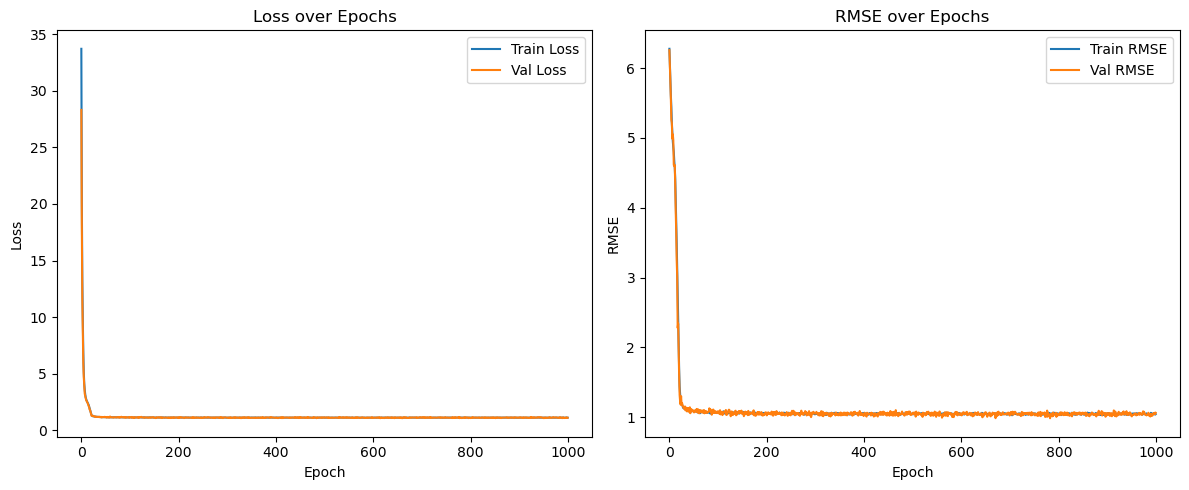

In [16]:

def negative_loglikelihood(targets, estimated_distribution):
    return -estimated_distribution.log_prob(targets)


num_epochs = 1000
prob_bnn_model = create_probablistic_bnn_model(train_size)
run_experiment(prob_bnn_model, negative_loglikelihood, train_dataset, test_dataset)

Now let's produce an output from the model given the test examples. The output is now a distribution, and we can use its mean and variance to compute the confidence intervals (CI) of the prediction.

In [17]:
prediction_distribution = prob_bnn_model(examples)
prediction_mean = prediction_distribution.mean().numpy().tolist()
prediction_stdv = prediction_distribution.stddev().numpy()

# The 95% CI is computed as mean ± (1.96 * stdv)
upper = (prediction_mean + (1.96 * prediction_stdv)).tolist()
lower = (prediction_mean - (1.96 * prediction_stdv)).tolist()
prediction_stdv = prediction_stdv.tolist()

for idx in range(sample):
    print(
        f"Prediction mean: {round(prediction_mean[idx][0], 2)}, "
        f"stddev: {round(prediction_stdv[idx][0], 2)}, "
        f"95% CI: [{round(upper[idx][0], 2)} - {round(lower[idx][0], 2)}]"
        f" - Actual: {targets[idx]}"
    )

Prediction mean: 6.33, stddev: 0.85, 95% CI: [7.98 - 4.67] - Actual: 5.0
Prediction mean: 5.57, stddev: 0.73, 95% CI: [7.0 - 4.13] - Actual: 7.0
Prediction mean: 5.37, stddev: 0.63, 95% CI: [6.61 - 4.12] - Actual: 6.0
Prediction mean: 5.93, stddev: 0.84, 95% CI: [7.59 - 4.28] - Actual: 5.0
Prediction mean: 6.35, stddev: 0.85, 95% CI: [8.01 - 4.69] - Actual: 6.0
Prediction mean: 5.36, stddev: 0.62, 95% CI: [6.58 - 4.14] - Actual: 6.0
Prediction mean: 5.57, stddev: 0.73, 95% CI: [7.0 - 4.15] - Actual: 5.0
Prediction mean: 6.2, stddev: 0.84, 95% CI: [7.85 - 4.55] - Actual: 7.0
Prediction mean: 5.48, stddev: 0.66, 95% CI: [6.79 - 4.18] - Actual: 6.0
Prediction mean: 5.37, stddev: 0.63, 95% CI: [6.6 - 4.14] - Actual: 5.0
